In [1]:
## UROP Benchmarking exercise v1

# Import and initialise device param
import time
from models.BaseAgent import BaseAgent
import gymnasium as gym
import torch
import numpy as np
from gym_examples.utils.population import PopulationSimulation
from models.HITLDQNAgent import HITLDQNAgent
from models.HITLDRQNAgent import HITLDRQNAgent

device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

Hyperparameters
- Agent
    - Fixed setpoint temperature
    - DQN
    - DRQN
- Learning Param
	- batch size
	- lr
	- eps, eps decay, eps start, eps_end
- POMDP/MDP
- Reward
    - With energy
    - Without energy
- Irrational/ Rational
- Simulation
    - Vanilla
    - ~~Eplus or BOPTEST~~
- ~~Dropoff/ no dropoff~~
- ~~Population distribut~~


Learning Param Default:
memory_size=10000, 
batch_size=64, 
gamma=0.99, 
eps_start=0.9, 
eps_end=0.05, 
eps_decay=1000, 
tau=0.005, 
lr=1e-4

| Test  | Agent | Learning Param | POMDP/MDP | Reward | Irrational/Rational | Simulation |
|------------------|-------|----------------|-----------|----------------|---------------------|------------|
|   1   | Fixed |default|MDP|Only human comfort|Rational|Vanilla|
|   2   | DQN |default|MDP|Only human comfort|Rational|Vanilla|
|   3   | DRQN |default|MDP|Only human comfort|Rational|Vanilla|
|------------------|-------|----------------|-----------|----------------|---------------------|------------|
|   4   | Fixed |default|POMDP|Only human comfort|Rational|Vanilla|
|   5   | DQN |default|POMDP|Only human comfort|Rational|Vanilla|
|   6   | DRQN |default|POMDP|Only human comfort|Rational|Vanilla|
|------------------|-------|----------------|-----------|----------------|---------------------|------------|
|   7   | Fixed |default|POMDP|Energy + Human Comfort|Rational|Vanilla|
|   8   | DQN |default|POMDP|Energy + Human Comfort|Rational|Vanilla|
|   9   | DRQN |default|POMDP|Energy + Human Comfort|Rational|Vanilla|
|------------------|-------|----------------|-----------|----------------|---------------------|------------|
|   10   | Fixed |default|POMDP|Energy + Human Comfort|Irrational|Vanilla|
|   11   | DQN |default|POMDP|Energy + Human Comfort|Irrational|Vanilla|
|   12   | DRQN |default|POMDP|Energy + Human Comfort|Irrational|Vanilla|



# Test 1, 2, 3

In [2]:
# Setpoint baseline
def setpoint_benchmark(setpt_temp:int, env:gym.Env, episodes: int, device):
    """Run setpoint temperature using gym environment while being offline"""
    rewards = []
    for i_episode in range(episodes):
        print(f'######------------------------------------EPISODE {i_episode}------------------------------------######')
        observation, info = env.reset()
        ep_rewards = 0
        is_done = False
        while not is_done:
            observation, reward, terminated, truncated, info = env.step(setpt_temp)
            reward = torch.tensor([np.float32(reward)], device=device)
            ep_rewards += reward
            is_done = terminated or truncated
        rewards.append(ep_rewards.item())
            
    return rewards

In [3]:
# Plotting multiple rounds of rewards
from typing import List
from matplotlib import pyplot as plt

def plot_multiple_runs(all_rewards: List[List[int]]):
    all_rewards = np.array(all_rewards)

    # Calculate max, min, and mean rewards
    max_rewards = np.max(all_rewards, axis=0)
    min_rewards = np.min(all_rewards, axis=0)
    mean_rewards = np.mean(all_rewards, axis=0)

    # Plot the area graph
    plt.figure(figsize=(10, 5))
    plt.fill_between(range(len(max_rewards)), min_rewards, max_rewards, color='gray', alpha=0.3, label='Min to Max')
    plt.plot(mean_rewards, label='Mean', color='blue')
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.title('Reward Comparison over Multiple Runs')
    plt.legend()

    plt.ioff()
    plt.show()


In [9]:
# Test 1,2,3
NUM_EPISODES = 500 if torch.cuda.is_available() or torch.backends.mps.is_available() else 50 # Number of days (each episode is a day)
NUM_RUNS = 5

# Environment Initialisation
population = PopulationSimulation(2.9, 1.05, 0.5, 0.25, 200, 80)
env = gym.make("HITLAirconEnvironment-v0", population_simulation=population, is_render=False, check_optimal=False ,w_usercomfort=1)

/Users/waishunlee/Documents/UROP/hitl_hvac/.venv/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:32: UserWarning: WARN: A Box observation space maximum and minimum values are equal. Actual equal coordinates: [(603, 0)]
  logger.warn(


######------------------------------------Run #0------------------------------------######
######------------------------------------EPISODE 0------------------------------------######


/Users/waishunlee/Documents/UROP/hitl_hvac/.venv/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:135: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/Users/waishunlee/Documents/UROP/hitl_hvac/.venv/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/Users/waishunlee/Documents/UROP/hitl_hvac/.venv/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:135: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/Users/waishunlee/Documents/UROP/hitl_hvac/.venv/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `step()` method is not wit

######------------------------------------EPISODE 1------------------------------------######
######------------------------------------EPISODE 2------------------------------------######
######------------------------------------EPISODE 3------------------------------------######
######------------------------------------EPISODE 4------------------------------------######
######------------------------------------EPISODE 5------------------------------------######
######------------------------------------EPISODE 6------------------------------------######
######------------------------------------EPISODE 7------------------------------------######
######------------------------------------EPISODE 8------------------------------------######
######------------------------------------EPISODE 9------------------------------------######
######------------------------------------EPISODE 10------------------------------------######
######------------------------------------EPISODE 11-------

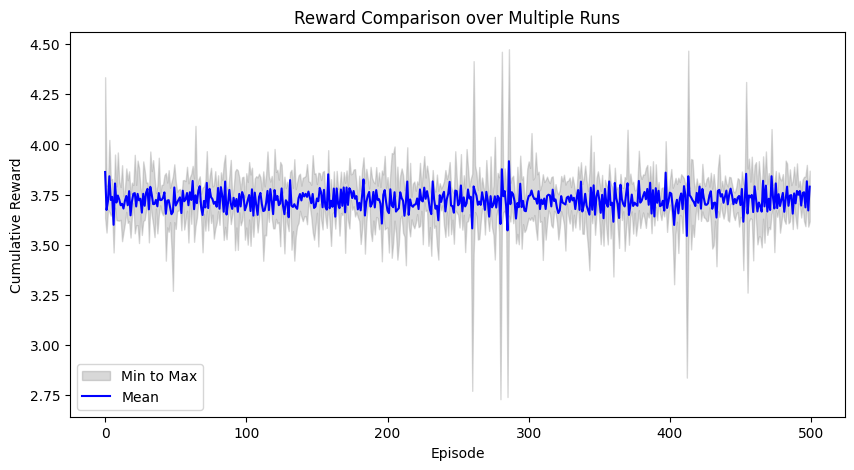

In [10]:
# Training
all_rewards = []
for i in range(NUM_RUNS):
    print(f'######------------------------------------Run #{i}------------------------------------######')
    rewards = setpoint_benchmark(24, env, NUM_EPISODES, device=device)
    all_rewards.append(rewards)

# print(all_rewards)
plot_multiple_runs(all_rewards)


In [4]:
def train(agent:BaseAgent, env:gym.Env, episodes: int, device, is_exploring:bool):
    """Train agent using gym environment while being offline"""

    rewards = []

    agent.reset_replay_memory() # Same train function has the same episodic memory
    agent.set_exploring(True)

    for i_episode in range(episodes):
        print(f'######------------------------------------EPISODE {i_episode}------------------------------------######')
        observation, info = env.reset()
        state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        ep_rewards = 0
        is_done = False
        
        while not is_done: 
            action = agent.select_action(state)
            observation, reward, terminated, truncated, info = env.step(action.item())
            reward = torch.tensor([np.float32(reward)], device=device)
            ep_rewards += reward
            
            is_done = terminated or truncated
            next_state = None if terminated else torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
            # start_m = time.time()
            agent.memorize(state, action, next_state, reward)
            state = next_state
            agent.optimize_model()
        

        rewards.append(ep_rewards.item())
            
    return agent, rewards

######------------------------------------Run #{i}...------------------------------------######
######------------------------------------EPISODE 0------------------------------------######
######------------------------------------EPISODE 1------------------------------------######
######------------------------------------EPISODE 2------------------------------------######
######------------------------------------EPISODE 3------------------------------------######


/Users/waishunlee/Documents/UROP/hitl_hvac/models/HITLDQNAgent.py:117: UserWarning: MPS: nonzero op is supported natively starting from macOS 13.0. Falling back on CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Indexing.mm:334.)
  next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1).values


######------------------------------------EPISODE 4------------------------------------######
######------------------------------------EPISODE 5------------------------------------######
######------------------------------------EPISODE 6------------------------------------######
######------------------------------------EPISODE 7------------------------------------######
######------------------------------------EPISODE 8------------------------------------######
######------------------------------------EPISODE 9------------------------------------######
######------------------------------------EPISODE 10------------------------------------######
######------------------------------------EPISODE 11------------------------------------######
######------------------------------------EPISODE 12------------------------------------######
######------------------------------------EPISODE 13------------------------------------######
######------------------------------------EPISODE 14----

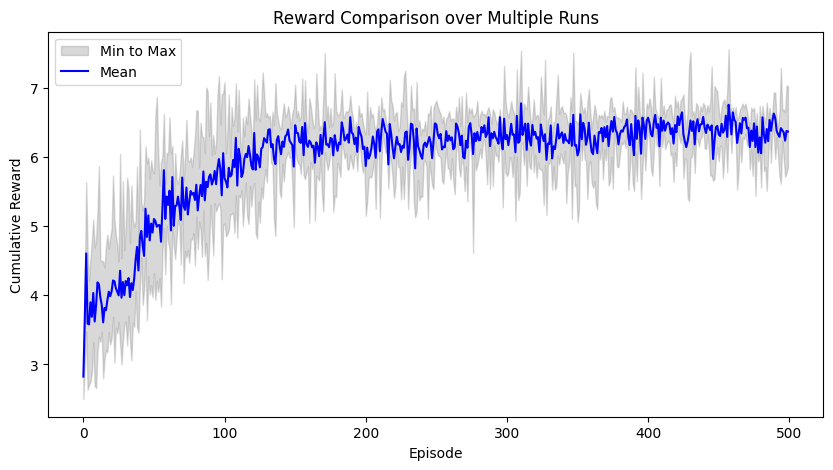

In [12]:
# Test 2
state, info = env.reset()
n_observations = len(state)
n_actions = env.action_space.n

# Training
all_rewards = []
for i in range(NUM_RUNS):
    agent = HITLDQNAgent(n_observations, n_actions, device, 
                     memory_size=10000, 
                     batch_size=64, 
                     gamma=0.90 , 
                     eps_start=0.9, 
                     eps_end=0.05, 
                     eps_decay=1000, 
                     tau=0.005, 
                     lr=1e-4)
    print("######------------------------------------Run #{i}...------------------------------------######")
    _, rewards = train(agent, env, NUM_EPISODES, device, True)
    all_rewards.append(rewards)
print(all_rewards)
plot_multiple_runs(all_rewards)

In [6]:
def train_w_reset_h(agent:BaseAgent, env:gym.Env, episodes: int, device, is_exploring:bool):
    """Train agent using gym environment while being offline"""

    rewards = []

    agent.reset_replay_memory() # Same train function has the same episodic memory
    agent.set_exploring(True)

    for i_episode in range(episodes):
        print(f'######------------------------------------EPISODE {i_episode}------------------------------------######')
        observation, info = env.reset()
        state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        ep_rewards = 0
        is_done = False        
        while not is_done:
            action = agent.select_action(state)
            observation, reward, terminated, truncated, info = env.step(action.item())
            reward = torch.tensor([np.float32(reward)], device=device)
            ep_rewards += reward
            
            is_done = terminated or truncated
            next_state = None if terminated else torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
            agent.memorize(state, action, next_state, reward)
            state = next_state
            agent.optimize_model()

        rewards.append(ep_rewards.item())

        agent.reset_hidden_state() # Reset the hidden state of the agent

    return agent, rewards

######------------------------------------Run #{i}...------------------------------------######
######------------------------------------EPISODE 0------------------------------------######
######------------------------------------EPISODE 1------------------------------------######
######------------------------------------EPISODE 2------------------------------------######
######------------------------------------EPISODE 3------------------------------------######
######------------------------------------EPISODE 4------------------------------------######
######------------------------------------EPISODE 5------------------------------------######
######------------------------------------EPISODE 6------------------------------------######
######------------------------------------EPISODE 7------------------------------------######
######------------------------------------EPISODE 8------------------------------------######
######------------------------------------EPISODE 9-------

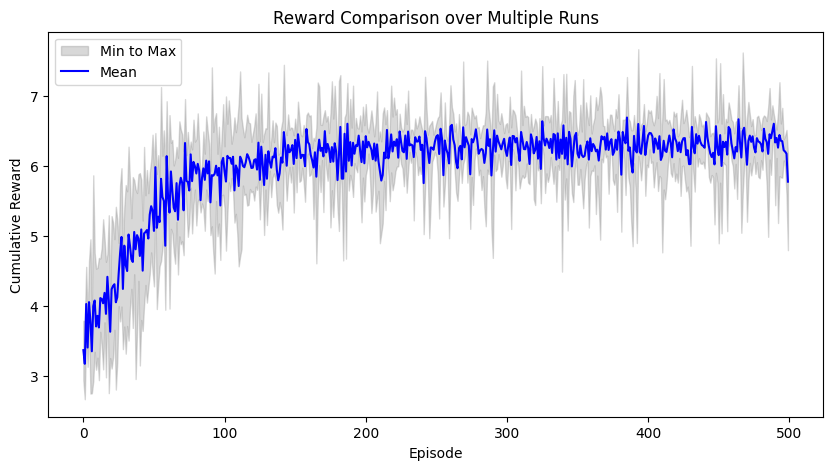

In [14]:
# Test 3
state, info = env.reset()
n_observations = len(state)
n_actions = env.action_space.n

# Training
all_rewards = []
for i in range(NUM_RUNS):
    agent = HITLDRQNAgent(n_observations, n_actions, device, 
                        memory_size=10000, 
                        batch_size=64, 
                        gamma=0.99, 
                        eps_start=0.9, 
                        eps_end=0.05, 
                        eps_decay=1000, 
                        tau=0.005, 
                        lr=1e-4)
    print("######------------------------------------Run #{i}...------------------------------------######")
    _, rewards = train_w_reset_h(agent, env, NUM_EPISODES, device, True)
    all_rewards.append(rewards)
print(all_rewards)
plot_multiple_runs(all_rewards)

# Test 4, 5, 6

In [15]:
# Test 4, 5, 6
NUM_EPISODES = 500 if torch.cuda.is_available() or torch.backends.mps.is_available() else 50 # Number of days (each episode is a day)
NUM_RUNS = 5

# Environment Initialisation
population = PopulationSimulation(2.9, 1.05, 0.5, 0.25, 200, 80)
env = gym.make("HITLAPOMDPirconEnvironment-v0", population_simulation=population, is_render=False, check_optimal=False ,w_usercomfort=1)

######------------------------------------Run #0------------------------------------######
######------------------------------------EPISODE 0------------------------------------######
######------------------------------------EPISODE 1------------------------------------######
######------------------------------------EPISODE 2------------------------------------######
######------------------------------------EPISODE 3------------------------------------######
######------------------------------------EPISODE 4------------------------------------######
######------------------------------------EPISODE 5------------------------------------######
######------------------------------------EPISODE 6------------------------------------######
######------------------------------------EPISODE 7------------------------------------######
######------------------------------------EPISODE 8------------------------------------######
######------------------------------------EPISODE 9------------

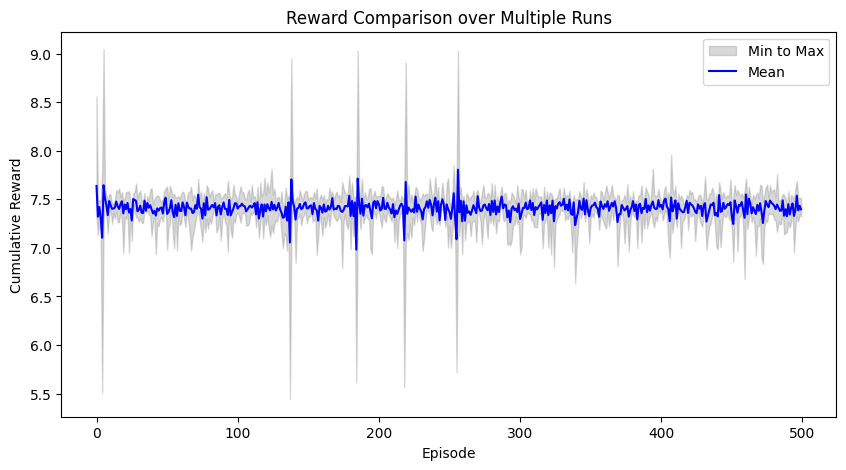

In [16]:
# Training
all_rewards = []
for i in range(NUM_RUNS):
    print(f'######------------------------------------Run #{i}------------------------------------######')
    rewards = setpoint_benchmark(24, env, NUM_EPISODES, device=device)
    all_rewards.append(rewards)

# print(all_rewards)
plot_multiple_runs(all_rewards)


######------------------------------------Run #{i}...------------------------------------######
######------------------------------------EPISODE 0------------------------------------######
######------------------------------------EPISODE 1------------------------------------######
######------------------------------------EPISODE 2------------------------------------######
######------------------------------------EPISODE 3------------------------------------######
######------------------------------------EPISODE 4------------------------------------######
######------------------------------------EPISODE 5------------------------------------######
######------------------------------------EPISODE 6------------------------------------######
######------------------------------------EPISODE 7------------------------------------######
######------------------------------------EPISODE 8------------------------------------######
######------------------------------------EPISODE 9-------

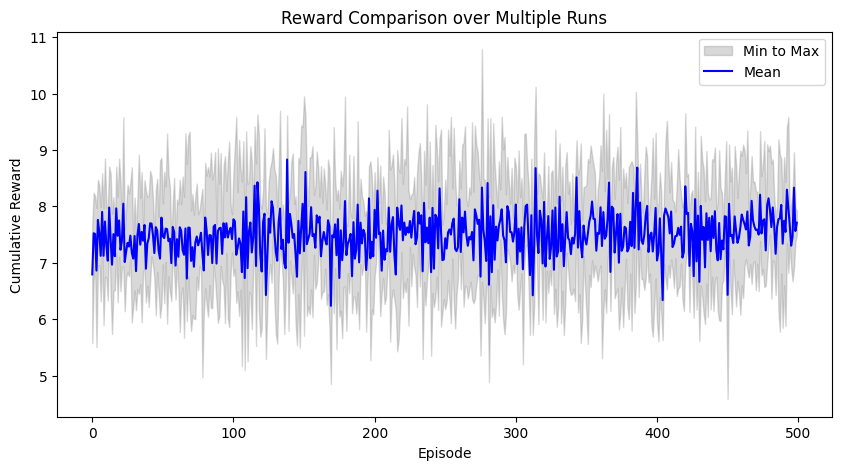

In [17]:
# Test 5
state, info = env.reset()
n_observations = len(state)
n_actions = env.action_space.n

# Training
all_rewards = []
for i in range(NUM_RUNS):
    agent = HITLDQNAgent(n_observations, n_actions, device, 
                     memory_size=10000, 
                     batch_size=64, 
                     gamma=0.90 , 
                     eps_start=0.9, 
                     eps_end=0.05, 
                     eps_decay=1000, 
                     tau=0.005, 
                     lr=1e-4)
    print("######------------------------------------Run #{i}...------------------------------------######")
    _, rewards = train(agent, env, NUM_EPISODES, device, True)
    all_rewards.append(rewards)
print(all_rewards)
plot_multiple_runs(all_rewards)

######------------------------------------Run #{i}...------------------------------------######
######------------------------------------EPISODE 0------------------------------------######
######------------------------------------EPISODE 1------------------------------------######
######------------------------------------EPISODE 2------------------------------------######
######------------------------------------EPISODE 3------------------------------------######
######------------------------------------EPISODE 4------------------------------------######
######------------------------------------EPISODE 5------------------------------------######
######------------------------------------EPISODE 6------------------------------------######
######------------------------------------EPISODE 7------------------------------------######
######------------------------------------EPISODE 8------------------------------------######
######------------------------------------EPISODE 9-------

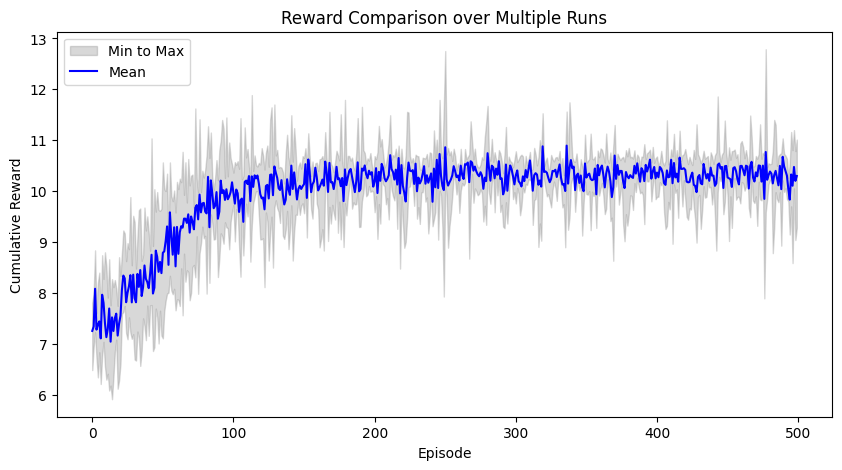

In [18]:
# Test 6
state, info = env.reset()
n_observations = len(state)
n_actions = env.action_space.n

# Training
all_rewards = []
for i in range(NUM_RUNS):
    agent = HITLDRQNAgent(n_observations, n_actions, device, 
                        memory_size=10000, 
                        batch_size=64, 
                        gamma=0.99, 
                        eps_start=0.9, 
                        eps_end=0.05, 
                        eps_decay=1000, 
                        tau=0.005, 
                        lr=1e-4)
    print("######------------------------------------Run #{i}...------------------------------------######")
    _, rewards = train_w_reset_h(agent, env, NUM_EPISODES, device, True)
    all_rewards.append(rewards)
print(all_rewards)
plot_multiple_runs(all_rewards)

# Test 7, 8, 9
TODO: Figure out the relative weights where thermal comfort and energy
Take the variance of power score for 22-26 indoor temp - 28 ambient temp
Compare this value - should be of a similar when 25% are voting PMV?

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List

In [40]:
def multiobj_setpoint_benchmark(setpt_temp:int, env:gym.Env, episodes: int, device):
    """Run setpoint temperature using gym environment while being offline"""
    rewards = []
    comfort_rewards = []
    energy_rewards = []
    for i_episode in range(episodes):
        print(f'######------------------------------------EPISODE {i_episode}------------------------------------######')
        observation, info = env.reset()
        ep_rewards = 0
        ep_comfort_rewards = 0
        ep_energy_rewards = 0
        is_done = False
        while not is_done:
            observation, reward, terminated, truncated, info = env.step(setpt_temp)
            reward = torch.tensor([np.float32(reward)], device=device)
            ep_rewards += reward
            ep_comfort_rewards += info['comfort_score']
            ep_energy_rewards += info['power_score']

            is_done = terminated or truncated

        rewards.append(ep_rewards.item())
        comfort_rewards.append(ep_comfort_rewards)
        energy_rewards.append(ep_energy_rewards)
            
    return rewards, comfort_rewards, energy_rewards

In [8]:
def multiobj_plot_multiple_runs(all_rewards: List[List[int]], all_comfort_rewards: List[List[int]], all_energy_rewards: List[List[int]]):
    # Convert lists to numpy arrays
    all_rewards = np.array(all_rewards)
    all_comfort_rewards = np.array(all_comfort_rewards)
    all_energy_rewards = np.array(all_energy_rewards)

    # Calculate max, min, and mean rewards for each objective
    max_rewards = np.max(all_rewards, axis=0)
    min_rewards = np.min(all_rewards, axis=0)
    mean_rewards = np.mean(all_rewards, axis=0)

    c_max_rewards = np.max(all_comfort_rewards, axis=0)
    c_min_rewards = np.min(all_comfort_rewards, axis=0)
    c_mean_rewards = np.mean(all_comfort_rewards, axis=0)

    e_max_rewards = np.max(all_energy_rewards, axis=0)
    e_min_rewards = np.min(all_energy_rewards, axis=0)
    e_mean_rewards = np.mean(all_energy_rewards, axis=0)

    # Plot the area graphs
    plt.figure(figsize=(10, 5))

    # Plot for overall reward
    plt.fill_between(range(len(max_rewards)), min_rewards, max_rewards, color='gray', alpha=0.3, label='Overall Min to Max')
    plt.plot(mean_rewards, label='Overall Mean', color='blue')

    # Plot for comfort reward
    plt.fill_between(range(len(c_max_rewards)), c_min_rewards, c_max_rewards, color='lightgreen', alpha=0.3, label='Comfort Min to Max')
    plt.plot(c_mean_rewards, label='Comfort Mean', color='green')

    # Plot for energy reward
    plt.fill_between(range(len(e_max_rewards)), e_min_rewards, e_max_rewards, color='lightcoral', alpha=0.3, label='Energy Min to Max')
    plt.plot(e_mean_rewards, label='Energy Mean', color='red')

    # Set labels and title
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.title('Multi-objective Reward Comparison over Multiple Runs')
    plt.legend()

    plt.show()

# Example usage:
# multiobj_plot_multiple_runs(all_rewards, all_comfort_rewards, all_energy_rewards)


In [79]:
# Test 7, 8, 9
NUM_EPISODES = 200 if torch.cuda.is_available() or torch.backends.mps.is_available() else 50 # Number of days (each episode is a day)
NUM_RUNS = 2

# Environment Initialisation
population = PopulationSimulation(2.9, 1.05, 0.5, 0.25, 200, 80)

w_usercomfort=40
w_energy=1
w_sum = w_usercomfort + w_energy
w_usercomfort /=w_sum
w_energy /=w_sum

env = gym.make("AirconEnvironment-v0", population_simulation=population, is_render=False, check_optimal=False ,w_usercomfort=w_usercomfort, w_energy=w_energy)

######------------------------------------Run #0------------------------------------######
######------------------------------------EPISODE 0------------------------------------######
######------------------------------------EPISODE 1------------------------------------######
######------------------------------------EPISODE 2------------------------------------######
######------------------------------------EPISODE 3------------------------------------######
######------------------------------------EPISODE 4------------------------------------######
######------------------------------------EPISODE 5------------------------------------######
######------------------------------------EPISODE 6------------------------------------######
######------------------------------------EPISODE 7------------------------------------######
######------------------------------------EPISODE 8------------------------------------######
######------------------------------------EPISODE 9------------

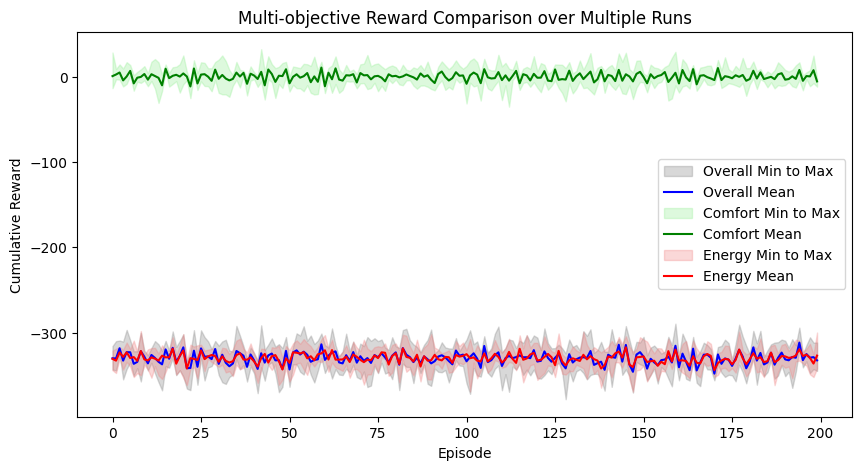

In [72]:
# Test 7
all_rewards = []
all_comfort_rewards = []
all_energy_rewards = []
for i in range(NUM_RUNS):
    print(f'######------------------------------------Run #{i}------------------------------------######')
    rewards, comfort_rewards, energy_rewards = multiobj_setpoint_benchmark(24, env, NUM_EPISODES, device=device)
    all_rewards.append(rewards)
    all_comfort_rewards.append(comfort_rewards)
    all_energy_rewards.append(energy_rewards)

# print(all_rewards)
multiobj_plot_multiple_runs(all_rewards, all_comfort_rewards, all_energy_rewards)

In [73]:
# Weight utils
def normalize_rewards(rewards):
    min_reward = min(rewards)
    max_reward = max(rewards)
    return [(r - min_reward) / (max_reward - min_reward) for r in rewards]

def compute_statistics(rewards):
    mean_reward = np.mean(rewards)
    variance_reward = np.var(rewards)
    return mean_reward, variance_reward

def calculate_weights(variance_1, variance_2):
    total_variance = variance_1 + variance_2
    weight_1 = 1 / variance_1 / total_variance
    weight_2 = 1 / variance_2 / total_variance
    return weight_1, weight_2

def get_combination_weights(reward_1, reward_2):
    # Normalize the rewards
    # normalized_reward_1 = normalize_rewards(reward_1)
    # normalized_reward_2 = normalize_rewards(reward_2)

    # Compute statistics
    _, variance_1 = compute_statistics(reward_1)
    _, variance_2 = compute_statistics(reward_2)
    print(f'Energy var:{variance_2}, Comfort var:{variance_1}')

    # Calculate weights
    weight_1, weight_2 = calculate_weights(variance_1, variance_2)
    weight_1 /= weight_2
    weight_2 /= weight_2
    return weight_1, weight_2

# Example usage:
weight_1, weight_2 = get_combination_weights(np.mean(all_comfort_rewards, axis=0), np.mean(all_energy_rewards, axis=0))
print(f"Weight for reward 1: {weight_1}")
print(f"Weight for reward 2: {weight_2}")

Energy var:25.52153771315686, Comfort var:21.714704476719206
Weight for reward 1: 1.1753113076219408
Weight for reward 2: 1.0


In [74]:
def multiobj_train(agent:BaseAgent, env:gym.Env, episodes: int, device, is_exploring:bool):
    """Train agent using gym environment while being offline"""

    rewards = []
    comfort_rewards = []
    energy_rewards = []

    agent.reset_replay_memory() # Same train function has the same episodic memory
    agent.set_exploring(True)

    for i_episode in range(episodes):
        print(f'######------------------------------------EPISODE {i_episode}------------------------------------######')
        observation, info = env.reset()
        state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        ep_rewards = 0
        ep_comfort_rewards = 0
        ep_energy_rewards = 0
        is_done = False
        
        while not is_done: 
            action = agent.select_action(state)
            observation, reward, terminated, truncated, info = env.step(action.item())
            reward = torch.tensor([np.float32(reward)], device=device)
            ep_rewards += reward
            ep_comfort_rewards += info['comfort_score']
            ep_energy_rewards += info['power_score']
            
            is_done = terminated or truncated
            next_state = None if terminated else torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
            # start_m = time.time()
            agent.memorize(state, action, next_state, reward)
            state = next_state
            agent.optimize_model()
        

        rewards.append(ep_rewards.item())
        comfort_rewards.append(ep_comfort_rewards)
        energy_rewards.append(ep_energy_rewards)
            
    return agent, rewards, comfort_rewards, energy_rewards

######------------------------------------Run #0...------------------------------------######
######------------------------------------EPISODE 0------------------------------------######
######------------------------------------EPISODE 1------------------------------------######
######------------------------------------EPISODE 2------------------------------------######
######------------------------------------EPISODE 3------------------------------------######
######------------------------------------EPISODE 4------------------------------------######
######------------------------------------EPISODE 5------------------------------------######
######------------------------------------EPISODE 6------------------------------------######
######------------------------------------EPISODE 7------------------------------------######
######------------------------------------EPISODE 8------------------------------------######
######------------------------------------EPISODE 9---------

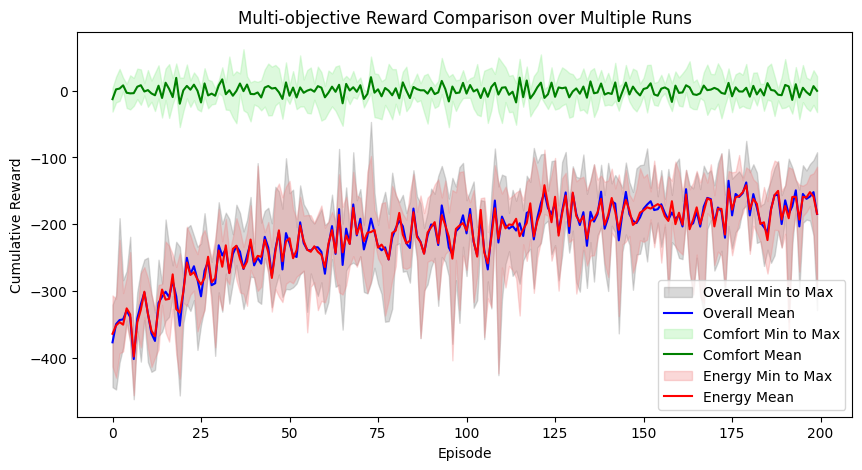

In [78]:
# Test 8
state, info = env.reset()
n_observations = len(state)
n_actions = env.action_space.n

# Training
all_rewards = []
all_comfort_rewards = []
all_energy_rewards = []

for i in range(NUM_RUNS):
    agent = HITLDQNAgent(n_observations, n_actions, device, 
                     memory_size=10000, 
                     batch_size=64, 
                     gamma=0.90 , 
                     eps_start=0.9, 
                     eps_end=0.05, 
                     eps_decay=1000, 
                     tau=0.005, 
                     lr=1e-4)
    print(f'######------------------------------------Run #{i}...------------------------------------######')
    _, rewards, comfort_rewards, energy_rewards = multiobj_train(agent, env, NUM_EPISODES, device, True)
    all_rewards.append(rewards)
    all_comfort_rewards.append(comfort_rewards)
    all_energy_rewards.append(energy_rewards)

multiobj_plot_multiple_runs(all_rewards, all_comfort_rewards, all_energy_rewards)

######------------------------------------Run #0...------------------------------------######
######------------------------------------EPISODE 0------------------------------------######
######------------------------------------EPISODE 1------------------------------------######
######------------------------------------EPISODE 2------------------------------------######
######------------------------------------EPISODE 3------------------------------------######
######------------------------------------EPISODE 4------------------------------------######
######------------------------------------EPISODE 5------------------------------------######
######------------------------------------EPISODE 6------------------------------------######
######------------------------------------EPISODE 7------------------------------------######
######------------------------------------EPISODE 8------------------------------------######
######------------------------------------EPISODE 9---------

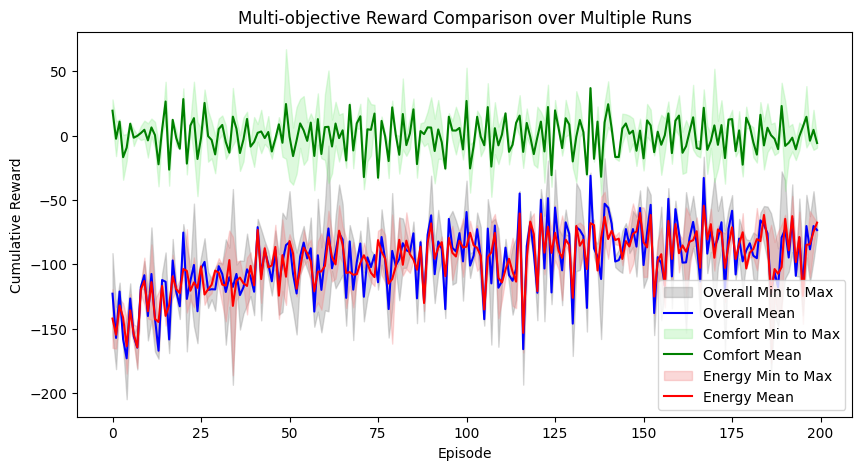

In [80]:
# Test 8.5 Varying weights 100:1
# Test 7, 8, 9
NUM_EPISODES = 200 if torch.cuda.is_available() or torch.backends.mps.is_available() else 50 # Number of days (each episode is a day)
NUM_RUNS = 2

# Environment Initialisation
population = PopulationSimulation(2.9, 1.05, 0.5, 0.25, 200, 80)

w_usercomfort=100
w_energy=1
w_sum = w_usercomfort + w_energy
w_usercomfort /=w_sum
w_energy /=w_sum

env = gym.make("AirconEnvironment-v0", population_simulation=population, is_render=False, check_optimal=False ,w_usercomfort=w_usercomfort, w_energy=w_energy)

## Training
state, info = env.reset()
n_observations = len(state)
n_actions = env.action_space.n

all_rewards = []
all_comfort_rewards = []
all_energy_rewards = []

for i in range(NUM_RUNS):
    agent = HITLDQNAgent(n_observations, n_actions, device, 
                     memory_size=10000, 
                     batch_size=64, 
                     gamma=0.90 , 
                     eps_start=0.9, 
                     eps_end=0.05, 
                     eps_decay=1000, 
                     tau=0.005, 
                     lr=1e-4)
    print(f'######------------------------------------Run #{i}...------------------------------------######')
    _, rewards, comfort_rewards, energy_rewards = multiobj_train(agent, env, NUM_EPISODES, device, True)
    all_rewards.append(rewards)
    all_comfort_rewards.append(comfort_rewards)
    all_energy_rewards.append(energy_rewards)

multiobj_plot_multiple_runs(all_rewards, all_comfort_rewards, all_energy_rewards)

######------------------------------------Run #0...------------------------------------######
######------------------------------------EPISODE 0------------------------------------######
######------------------------------------EPISODE 1------------------------------------######
######------------------------------------EPISODE 2------------------------------------######
######------------------------------------EPISODE 3------------------------------------######
######------------------------------------EPISODE 4------------------------------------######
######------------------------------------EPISODE 5------------------------------------######
######------------------------------------EPISODE 6------------------------------------######
######------------------------------------EPISODE 7------------------------------------######
######------------------------------------EPISODE 8------------------------------------######
######------------------------------------EPISODE 9---------

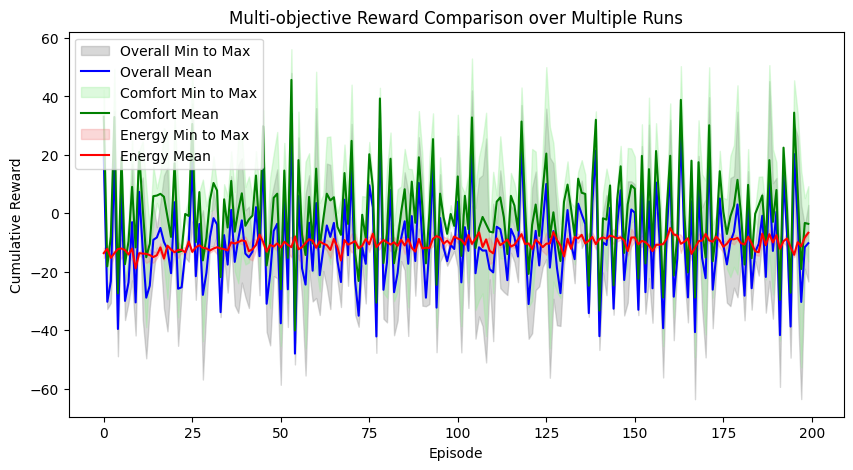

In [83]:
# Test 8.5 Varying weights 1000:1
w_usercomfort=1000
w_energy=1
w_sum = w_usercomfort + w_energy
w_usercomfort /=w_sum
w_energy /=w_sum
env = gym.make("AirconEnvironment-v0", population_simulation=population, is_render=False, check_optimal=False ,w_usercomfort=w_usercomfort, w_energy=w_energy)

## Training
state, info = env.reset()
n_observations = len(state)
n_actions = env.action_space.n

all_rewards = []
all_comfort_rewards = []
all_energy_rewards = []

for i in range(NUM_RUNS):
    agent = HITLDQNAgent(n_observations, n_actions, device, 
                     memory_size=10000, 
                     batch_size=128, 
                     gamma=0.90 , 
                     eps_start=0.9, 
                     eps_end=0.05, 
                     eps_decay=1000, 
                     tau=0.005, 
                     lr=1e-4)
    print(f'######------------------------------------Run #{i}...------------------------------------######')
    _, rewards, comfort_rewards, energy_rewards = multiobj_train(agent, env, NUM_EPISODES, device, True)
    all_rewards.append(rewards)
    all_comfort_rewards.append(comfort_rewards)
    all_energy_rewards.append(energy_rewards)

multiobj_plot_multiple_runs(all_rewards, all_comfort_rewards, all_energy_rewards)

######------------------------------------Run #0...------------------------------------######
######------------------------------------EPISODE 0------------------------------------######
######------------------------------------EPISODE 1------------------------------------######
######------------------------------------EPISODE 2------------------------------------######
######------------------------------------EPISODE 3------------------------------------######
######------------------------------------EPISODE 4------------------------------------######
######------------------------------------EPISODE 5------------------------------------######
######------------------------------------EPISODE 6------------------------------------######
######------------------------------------EPISODE 7------------------------------------######
######------------------------------------EPISODE 8------------------------------------######
######------------------------------------EPISODE 9---------

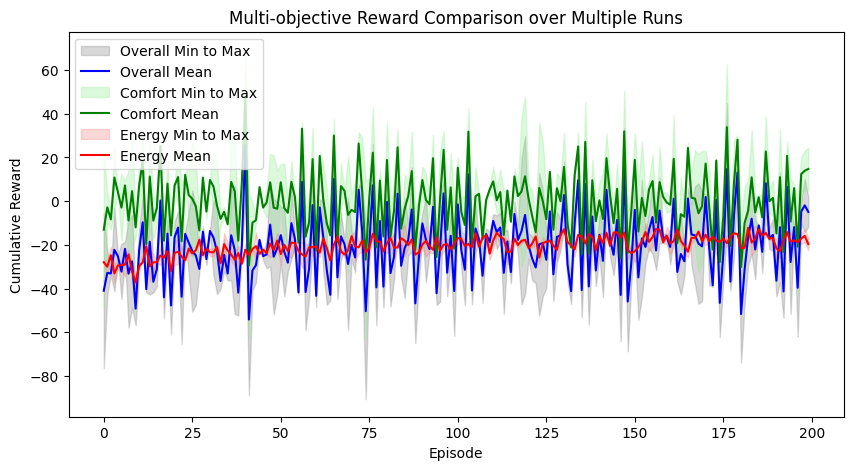

In [84]:
# Test 8.5 Varying weights 500:1
w_usercomfort=500
w_energy=1
w_sum = w_usercomfort + w_energy
w_usercomfort /=w_sum
w_energy /=w_sum
env = gym.make("AirconEnvironment-v0", population_simulation=population, is_render=False, check_optimal=False ,w_usercomfort=w_usercomfort, w_energy=w_energy)

## Training
state, info = env.reset()
n_observations = len(state)
n_actions = env.action_space.n

all_rewards = []
all_comfort_rewards = []
all_energy_rewards = []

for i in range(NUM_RUNS):
    agent = HITLDQNAgent(n_observations, n_actions, device, 
                     memory_size=10000, 
                     batch_size=128, 
                     gamma=0.90 , 
                     eps_start=0.9, 
                     eps_end=0.05, 
                     eps_decay=1000, 
                     tau=0.005, 
                     lr=1e-4)
    print(f'######------------------------------------Run #{i}...------------------------------------######')
    _, rewards, comfort_rewards, energy_rewards = multiobj_train(agent, env, NUM_EPISODES, device, True)
    all_rewards.append(rewards)
    all_comfort_rewards.append(comfort_rewards)
    all_energy_rewards.append(energy_rewards)

multiobj_plot_multiple_runs(all_rewards, all_comfort_rewards, all_energy_rewards)

######------------------------------------Run #0...------------------------------------######
######------------------------------------EPISODE 0------------------------------------######
######------------------------------------EPISODE 1------------------------------------######
######------------------------------------EPISODE 2------------------------------------######
######------------------------------------EPISODE 3------------------------------------######
######------------------------------------EPISODE 4------------------------------------######
######------------------------------------EPISODE 5------------------------------------######
######------------------------------------EPISODE 6------------------------------------######
######------------------------------------EPISODE 7------------------------------------######
######------------------------------------EPISODE 8------------------------------------######
######------------------------------------EPISODE 9---------

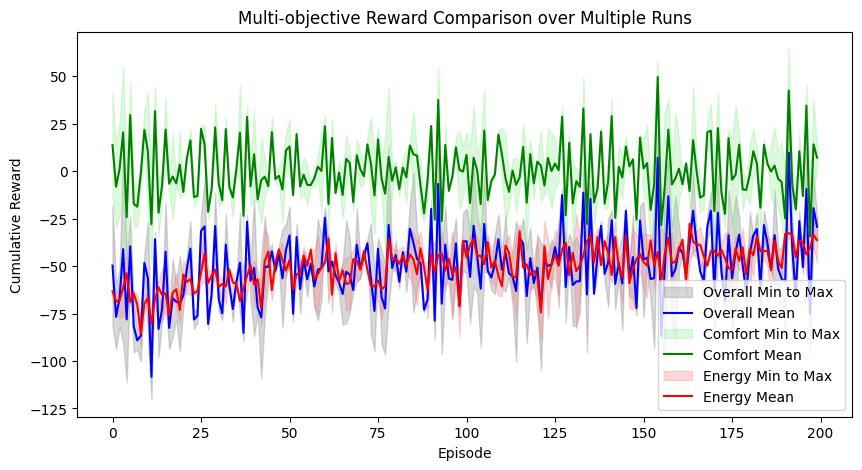

In [85]:
# Test 8.5 Varying weights 200:1
w_usercomfort=200
w_energy=1
w_sum = w_usercomfort + w_energy
w_usercomfort /=w_sum
w_energy /=w_sum
env = gym.make("AirconEnvironment-v0", population_simulation=population, is_render=False, check_optimal=False ,w_usercomfort=w_usercomfort, w_energy=w_energy)

## Training
state, info = env.reset()
n_observations = len(state)
n_actions = env.action_space.n

all_rewards = []
all_comfort_rewards = []
all_energy_rewards = []

for i in range(NUM_RUNS):
    agent = HITLDQNAgent(n_observations, n_actions, device, 
                     memory_size=10000, 
                     batch_size=128, 
                     gamma=0.90 , 
                     eps_start=0.9, 
                     eps_end=0.05, 
                     eps_decay=1000, 
                     tau=0.005, 
                     lr=1e-4)
    print(f'######------------------------------------Run #{i}...------------------------------------######')
    _, rewards, comfort_rewards, energy_rewards = multiobj_train(agent, env, NUM_EPISODES, device, True)
    all_rewards.append(rewards)
    all_comfort_rewards.append(comfort_rewards)
    all_energy_rewards.append(energy_rewards)

multiobj_plot_multiple_runs(all_rewards, all_comfort_rewards, all_energy_rewards)

In [86]:
def multiobj_train_w_reset_h(agent:BaseAgent, env:gym.Env, episodes: int, device, is_exploring:bool):
    """Train agent using gym environment while being offline"""

    rewards = []
    comfort_rewards = []
    energy_rewards = []

    agent.reset_replay_memory() # Same train function has the same episodic memory
    agent.set_exploring(True)

    for i_episode in range(episodes):
        print(f'######------------------------------------EPISODE {i_episode}------------------------------------######')
        observation, info = env.reset()
        state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        ep_rewards = 0
        ep_comfort_rewards = 0
        ep_energy_rewards = 0
        is_done = False        
        while not is_done:
            action = agent.select_action(state)
            observation, reward, terminated, truncated, info = env.step(action.item())
            reward = torch.tensor([np.float32(reward)], device=device)
            ep_rewards += reward
            ep_comfort_rewards += info['comfort_score']
            ep_energy_rewards += info['power_score']

            is_done = terminated or truncated
            next_state = None if terminated else torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
            agent.memorize(state, action, next_state, reward)
            state = next_state
            agent.optimize_model()

        rewards.append(ep_rewards.item())
        comfort_rewards.append(ep_comfort_rewards)
        energy_rewards.append(ep_energy_rewards)

        agent.reset_hidden_state() # Reset the hidden state of the agent

    return agent, rewards, comfort_rewards, energy_rewards

######------------------------------------Run #{i}...------------------------------------######
######------------------------------------EPISODE 0------------------------------------######
######------------------------------------EPISODE 1------------------------------------######
######------------------------------------EPISODE 2------------------------------------######
######------------------------------------EPISODE 3------------------------------------######
######------------------------------------EPISODE 4------------------------------------######
######------------------------------------EPISODE 5------------------------------------######
######------------------------------------EPISODE 6------------------------------------######
######------------------------------------EPISODE 7------------------------------------######
######------------------------------------EPISODE 8------------------------------------######
######------------------------------------EPISODE 9-------

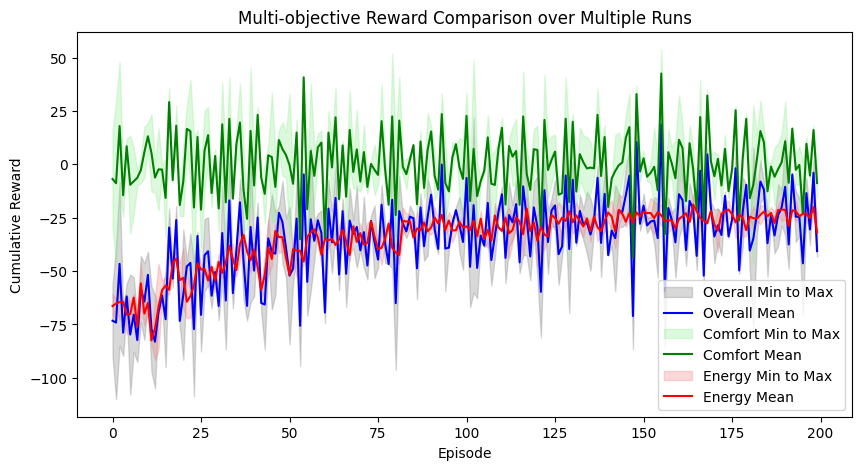

In [87]:
# Test 9
state, info = env.reset()
n_observations = len(state)
n_actions = env.action_space.n

# Training
all_rewards = []
all_comfort_rewards = []
all_energy_rewards = []

for i in range(NUM_RUNS):
    agent = HITLDRQNAgent(n_observations, n_actions, device, 
                        memory_size=10000, 
                        batch_size=64, 
                        gamma=0.99, 
                        eps_start=0.9, 
                        eps_end=0.05, 
                        eps_decay=1000, 
                        tau=0.005, 
                        lr=1e-4)
    print(f'######------------------------------------Run #{i}...------------------------------------######')
    _, rewards, comfort_rewards, energy_rewards = multiobj_train_w_reset_h(agent, env, NUM_EPISODES, device, True)
    all_rewards.append(rewards)
    all_comfort_rewards.append(comfort_rewards)
    all_energy_rewards.append(energy_rewards)

multiobj_plot_multiple_runs(all_rewards, all_comfort_rewards, all_energy_rewards)

# Test 10, 11, 12

In [ ]:
# Test 10, 11, 12
NUM_EPISODES = 200 if torch.cuda.is_available() or torch.backends.mps.is_available() else 50 # Number of days (each episode is a day)
NUM_RUNS = 5

# Environment Initialisation
population = PopulationSimulation(2.9, 1.05, 0.5, 0.25, 10, 2, irrational=True, irrational_B=0.5)

w_usercomfort=40
w_energy=1
w_sum = w_usercomfort + w_energy
w_usercomfort /=w_sum
w_energy /=w_sum

env = gym.make("AirconEnvironment-v0", population_simulation=population, is_render=False, check_optimal=False ,w_usercomfort=w_usercomfort, w_energy=w_energy)

In [ ]:
# Test 10
all_rewards = []
all_comfort_rewards = []
all_energy_rewards = []
for i in range(NUM_RUNS):
    print(f'######------------------------------------Run #{i}------------------------------------######')
    rewards, comfort_rewards, energy_rewards = multiobj_setpoint_benchmark(24, env, NUM_EPISODES, device=device)
    all_rewards.append(rewards)
    all_comfort_rewards.append(comfort_rewards)
    all_energy_rewards.append(energy_rewards)

multiobj_plot_multiple_runs(all_rewards, all_comfort_rewards, all_energy_rewards)

In [ ]:
# Test 11
state, info = env.reset()
n_observations = len(state)
n_actions = env.action_space.n

# Training
all_rewards = []
all_comfort_rewards = []
all_energy_rewards = []

for i in range(NUM_RUNS):
    agent = HITLDQNAgent(n_observations, n_actions, device, 
                     memory_size=10000, 
                     batch_size=64, 
                     gamma=0.90 , 
                     eps_start=0.9, 
                     eps_end=0.05, 
                     eps_decay=1000, 
                     tau=0.005, 
                     lr=1e-4)
    print(f'######------------------------------------Run #{i}...------------------------------------######')
    _, rewards, comfort_rewards, energy_rewards = multiobj_train(agent, env, NUM_EPISODES, device, True)
    all_rewards.append(rewards)
    all_comfort_rewards.append(comfort_rewards)
    all_energy_rewards.append(energy_rewards)

multiobj_plot_multiple_runs(all_rewards, all_comfort_rewards, all_energy_rewards)

In [ ]:
# Test 12
state, info = env.reset()
n_observations = len(state)
n_actions = env.action_space.n

# Training
all_rewards = []
all_comfort_rewards = []
all_energy_rewards = []

for i in range(NUM_RUNS):
    agent = HITLDRQNAgent(n_observations, n_actions, device, 
                        memory_size=10000, 
                        batch_size=64, 
                        gamma=0.99, 
                        eps_start=0.9, 
                        eps_end=0.05, 
                        eps_decay=1000, 
                        tau=0.005, 
                        lr=1e-4)
    print("######------------------------------------Run #{i}...------------------------------------######")
    _, rewards, comfort_rewards, energy_rewards = multiobj_train_w_reset_h(agent, env, NUM_EPISODES, device, True)
    all_rewards.append(rewards)
    all_comfort_rewards.append(comfort_rewards)
    all_energy_rewards.append(energy_rewards)

multiobj_plot_multiple_runs(all_rewards, all_comfort_rewards, all_energy_rewards)